# Final Project

## Predicting Residential Housing Prices in Washington DC

### Jim Scheffel

![](/desktop/istockphoto-809349300-612x612.jpg)

#### Problem Statement

The population in Washington DC is rapidly growing.  The increased desirability of DC proper has driven the cost of living quite high primarily due to the cost of housing which has nearly doubled in some areas in the last 10-15 years.  Rent Jungle reported the average rental cost in Washinton DC was 2,360.00 per month as of April 2019.  According to Black Knight, the median cost of a condo in Washington DC last year was 451,100.00 whereas the median cost of a single family home was 679,000.00.  When compared to 2009, these figures were 357,000.00 and 399,000.00 respectively.  The median household income as reported by the US Census Bureau for 2017 in the District was 82,372.00 which isn't enough to put home ownership in reach for many residents.  However, the cost of a house dropped by 1% last year and is expected to drop another 2% this year.  With interest rates remaining low and mortgage products with as little as 3% down, it might be good time to start watching housing prices in DC for a potential investment.

The cost of housing is driven by a number of factors including the location, number of rooms, bedrooms, bathrooms, square footage, the year it was built and if the property has been remodeled.

The goal of this project is to predict the price a home (detached or townhome/rowhouse) in Washington DC that could help a potential buyer understand if it's a good time to buy and if they are getting a good deal.

The measure of success would be to predict the cost of a house with a reasonable degree of accuarcy based on the criteria provided.

#### Data

I obtained this data set from Kaggle, but the original data source was Open Data DC.  The data contains both residential and condominium home types.  I decided to use only the residential data as it was a richer dataset and my intial exploration of the condo data did not yield very good results.  The orginal dataset has qualified and unqualified sale prices for houses starting in 1949 until 2018.  I decided to use the sales starting in 2002. This data is only looking at houses in Washington DC proper.  I also found that the average price in this data was higher than the median I turned up in my research.

#### Target Variable

I will be using Price as my taget variable.  The prices in the original dataset ranged from 4,950 to 22,000,000.  I will be scrubbing sales under 50,000 as they are unrealistic in the market for the timeframe chosen.  Also, parking spaces are sold as real estate in DC and can sell more than the cost of high end luxury car.

#### Feature Variables

I will be using no of bathrooms, no of half bathrooms, no of units, no of rooms, no of bedrooms, year built, year remodeled, year improved, no of stories, sale date, square footage, type of structure, overall grade, overall condition, no of fireplaces, land area, neighborhood and quadrant as my feature variables.  I also chose to remove 0 values as for feature columns as they were only a small fraction of the data. I subsitituted year built for year remodeled where it was missing as this was determined to be an important feature in the data exploration.

#### Models

I am working with regression models as I am trying to predict a numeric value.  I used KFold Linear Regression, Decision Tree Regression, Random Forest Regression and Bagged Decision Trees.  I'm using R^2 which is good for comparing models and Mean Absolute Error which is a good measure of the average error from the line which represents price as my measures.

##### This is what 22 million dollars will buy you in Washington DC

![](/desktop/genMid.1004405114_0.jpg)

#### Import and Clean Data

In [190]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import median
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline

In [191]:
filepath = '../data/DC_Properties.csv'
properties = pd.read_csv(filepath)

C:\Users\jim44\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19,20,21,22,23,24,33,34,35,37,43,45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [192]:
houses = properties[properties.SOURCE != 'Condominium'] ## filter for Residential only

In [193]:
houses = houses[houses.QUALIFIED != 'U'] ## remove unqualified sales

In [194]:
houses = houses[houses.loc[:, 'PRICE'] > 50000] ## filter out sales under 50k as these could be parking spaces

In [195]:
houses = houses[pd.notnull(houses['AYB'])] ## remove house without prices

In [196]:
houses = houses[pd.notnull(houses['STORIES'])] ## remore houses with 0 stories

In [197]:
houses['YR_RMDL'] = houses.YR_RMDL.fillna(houses.AYB) ## fill empty year remodeled with year built

In [198]:
houses = houses[houses.loc[:, 'BATHRM'] != 0]## remove 0 values

In [199]:
houses = houses[houses.loc[:, 'NUM_UNITS'] != 0]  ## remove 0 values

In [200]:
houses = houses[houses.loc[:, 'ROOMS'] != 0]  ## remove 0 values

In [201]:
houses = houses[houses.loc[:, 'BEDRM'] != 0]  ## remove 0 values

In [202]:
houses = houses[houses.loc[:, 'STORIES'] != 0]  ## remove 0 values

In [203]:
houses['SALEDATE'] = pd.to_datetime(houses['SALEDATE']) ## convert sale date to datetime

In [204]:
houses['SALEDATE'] = houses['SALEDATE'].dt.year ## convert sale date to sale year

In [205]:
houses = houses[houses.loc[:, 'SALEDATE'] > 2001] ## filter to houses should after 2001

In [206]:
houses = houses.reset_index()

In [207]:
houses.columns

Index(['index', 'Unnamed: 0', 'BATHRM', 'HF_BATHRM', 'HEAT', 'AC', 'NUM_UNITS',
       'ROOMS', 'BEDRM', 'AYB', 'YR_RMDL', 'EYB', 'STORIES', 'SALEDATE',
       'PRICE', 'QUALIFIED', 'SALE_NUM', 'GBA', 'BLDG_NUM', 'STYLE', 'STRUCT',
       'GRADE', 'CNDTN', 'EXTWALL', 'ROOF', 'INTWALL', 'KITCHENS',
       'FIREPLACES', 'USECODE', 'LANDAREA', 'GIS_LAST_MOD_DTTM', 'SOURCE',
       'CMPLX_NUM', 'LIVING_GBA', 'FULLADDRESS', 'CITY', 'STATE', 'ZIPCODE',
       'NATIONALGRID', 'LATITUDE', 'LONGITUDE', 'ASSESSMENT_NBHD',
       'ASSESSMENT_SUBNBHD', 'CENSUS_TRACT', 'CENSUS_BLOCK', 'WARD', 'SQUARE',
       'X', 'Y', 'QUADRANT'],
      dtype='object')

In [208]:
columns = ['BATHRM', 'HF_BATHRM', 'ROOMS', 'NUM_UNITS',
           'BEDRM', 'AYB', 'YR_RMDL', 'EYB', 'STORIES' , 'SALEDATE', 'PRICE',
           'GBA', 'STRUCT', 'GRADE', 'CNDTN', 'FIREPLACES', 'LANDAREA', 'ASSESSMENT_NBHD', 'QUADRANT']
houses = houses.loc[:, columns]  ## select target and feature columns

In [209]:
houses.rename(columns={'BATHRM':'bath','HF_BATHRM':'hlf_bath','ROOMS':'rooms','NUM_UNITS':'num_units','BEDRM':'bedrm',
                       'AYB':'yr_blt','YR_RMDL':'yr_rmdl','EYB':'yr_imprv','STORIES':'stories','SALEDATE':'yr_sold','PRICE':'price',
                       'GBA':'sq_ft','STRUCT':'str_type','GRADE':'grade','CNDTN':'condition','FIREPLACES':'fireplaces',
                      'LANDAREA':'lotsize','ASSESSMENT_NBHD':'neighborhood','QUADRANT':'quadrant'}, inplace=True)  ## rename for clarity

In [210]:
houses.head()

,bath,hlf_bath,rooms,num_units,bedrm,yr_blt,yr_rmdl,yr_imprv,stories,yr_sold,price,sq_ft,str_type,grade,condition,fireplaces,lotsize,neighborhood,quadrant
0,4,0,8,2.0,4,1910.0,1988.0,1972,3.0,2003,1095000.0,2522.0,Row Inside,Very Good,Good,5,1680,Old City 2,NW
1,3,1,9,2.0,5,1910.0,2009.0,1984,3.0,2016,2100000.0,2522.0,Row Inside,Very Good,Very Good,4,1680,Old City 2,NW
2,3,1,8,2.0,5,1900.0,2003.0,1984,3.0,2006,1602000.0,2484.0,Row Inside,Very Good,Good,3,1680,Old City 2,NW
3,3,2,10,1.0,5,1913.0,1913.0,1972,4.0,2010,1950000.0,5344.0,Row Inside,Very Good,Good,4,2196,Old City 2,NW
4,3,1,8,2.0,4,1906.0,2011.0,1972,3.0,2011,1050000.0,2401.0,Row Inside,Very Good,Average,1,1627,Old City 2,NW


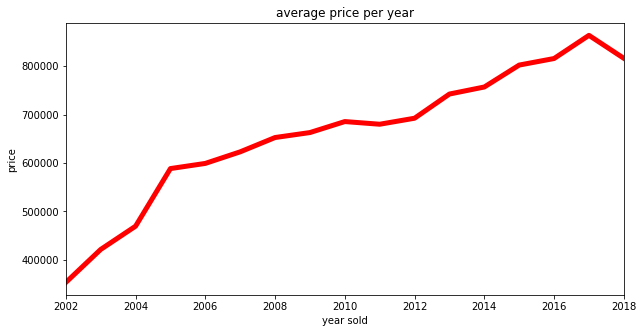

In [211]:
avg_price_year = houses.groupby('yr_sold')['price'].mean()
ax = avg_price_year.plot(kind='line', figsize=(10,5), color='r', linewidth=5)
ax.set_xlabel('year sold')
ax.set_ylabel('price')
ax.set_title('average price per year');

##### Washinton DC Neighborhoods

![](/desktop/DC_neighborhoods_map.png)

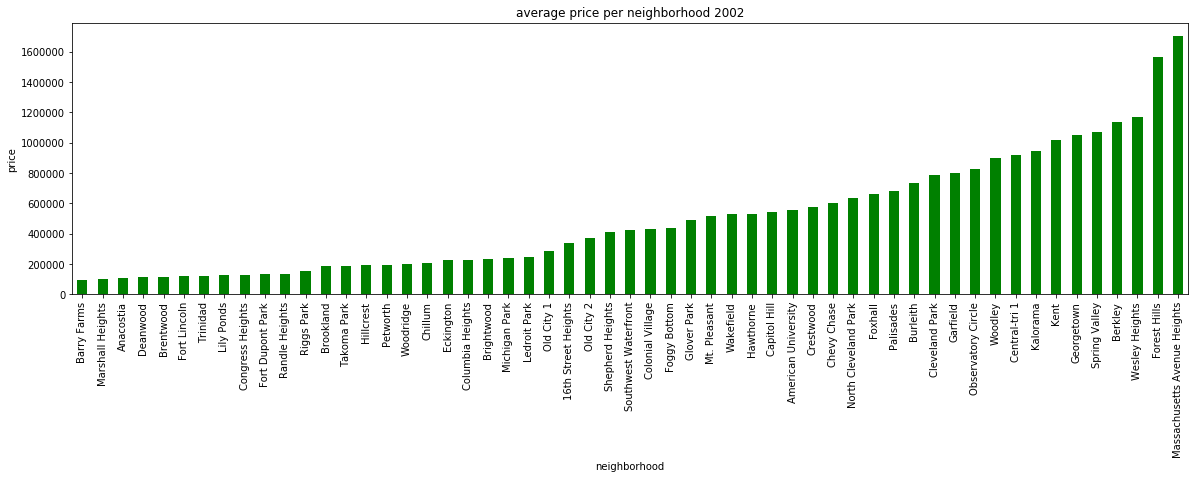

In [212]:
houses_2002 = houses[houses.loc[:, 'yr_sold'] == 2002]
avg_price_neighborhood_2002 = houses_2002.groupby('neighborhood')['price'].mean().sort_values()
ax = avg_price_neighborhood_2002.plot(kind='bar', figsize=(20,5), color='g')
ax.set_xlabel('neighborhood')
ax.set_ylabel('price')
ax.set_title('average price per neighborhood 2002');


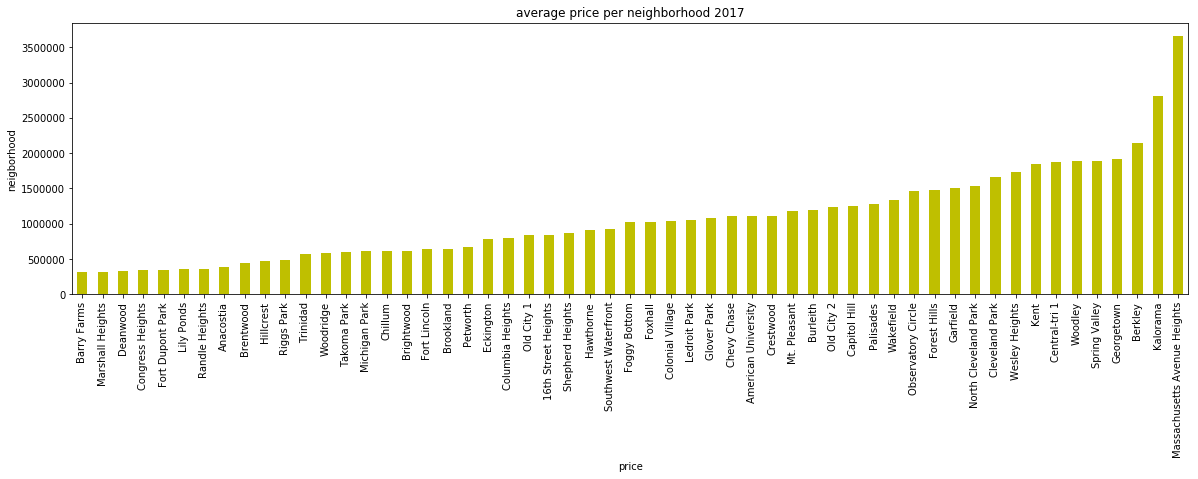

In [213]:
houses_2017 = houses[houses.loc[:, 'yr_sold'] == 2017]
avg_price_neighborhood_2017 = houses_2017.groupby('neighborhood')['price'].mean().sort_values()
ax = avg_price_neighborhood_2017.plot(kind='bar', figsize=(20,5), color='y')
ax.set_xlabel('price')
ax.set_ylabel('neigborhood')
ax.set_title('average price per neighborhood 2017');

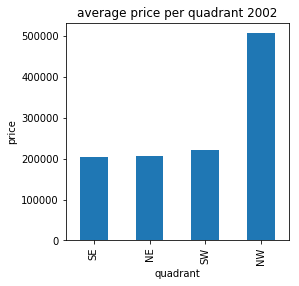

In [214]:
houses_2002 = houses[houses.loc[:, 'yr_sold'] == 2002]
avg_price_quadrant_2002 = houses_2002.groupby('quadrant')['price'].mean().sort_values()

ax = avg_price_quadrant_2002.plot(kind='bar', figsize=(4,4))
ax.set_xlabel('quadrant')
ax.set_ylabel('price')
ax.set_title('average price per quadrant 2002');

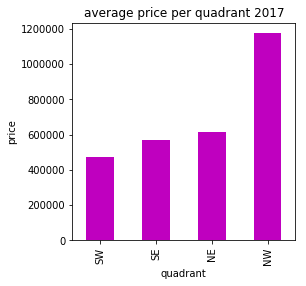

In [215]:
houses_2017= houses[houses.loc[:, 'yr_sold'] == 2017]
avg_price_quadrant_2017 = houses_2017.groupby('quadrant')['price'].mean().sort_values()

ax = avg_price_quadrant_2017.plot(kind='bar', figsize=(4,4), color='m')
ax.set_xlabel('quadrant')
ax.set_ylabel('price')
ax.set_title('average price per quadrant 2017');

In [216]:
houses = pd.get_dummies(houses, columns=['str_type', 'grade', 'condition', 'neighborhood', 'quadrant'], drop_first=True) 
## convert categorical variables to numeric

In [217]:
houses.shape  ## I end up with 1 target and 92 features

(38424, 93)

#### Modeling Data

##### Train Test Split

In [218]:
target_col = houses.loc[:, 'price']
feature_cols = houses.drop('price', axis='columns')
y = target_col
X = feature_cols

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7, test_size=.3, random_state=10)

##### KFold Linear Regression

In [219]:
lr = LinearRegression()

kf = KFold(50, shuffle=True)

lr_grid = GridSearchCV(
            estimator=lr, 
            param_grid={}, 
            cv=kf, 
            return_train_score=True)

lr_grid.fit(X, y)

results = lr_grid.cv_results_

print(results['mean_test_score'])  
print(results['mean_train_score']) ## These R^2 values are not bad.  Minimal variance but there is bias.

[0.83369169]
[0.84102057]


##### Fit the best Linear Regression model

In [220]:
linreg = lr_grid.best_estimator_

linreg.fit(X_train, y_train)

print('Linear Regression Test R^2:', linreg.score(X_test, y_test))       
print('Linear Regression Training R^2:', linreg.score(X_train, y_train))

print('Linear Regression Test MAE:', mean_absolute_error(y_test, linreg.predict(X_test)))
print('Linear Regression Training MAE:', mean_absolute_error(y_train, linreg.predict(X_train)))

Linear Regression Test R^2: 0.8289621252210831
Linear Regression Training R^2: 0.8444988224375176
Linear Regression Test MAE: 138408.66428597335
Linear Regression Training MAE: 134066.51683644875


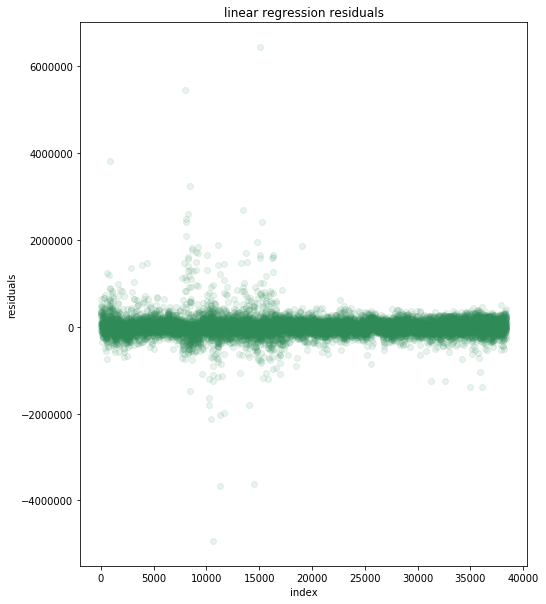

In [221]:
fig, ax = plt.subplots(figsize=(8,10))
residuals = y_test - linreg.predict(X_test)
ax.scatter(x=y_test.index, y=residuals, alpha=.1, color='seagreen');
ax.set_xlabel('index')
ax.set_ylabel('residuals')
ax.set_title('linear regression residuals'); 
## shows the spread of residuals across the test set to help visually interpret MAE

##### KFold Decision Tree Regressor

In [222]:
dtr = DecisionTreeRegressor(max_depth=100)
kf = KFold(25, shuffle=True, random_state=1)

dtr_grid = GridSearchCV(
            estimator=dtr,
            param_grid={},
            return_train_score=True,
            cv=kf,
            )

dtr_grid.fit(X, y)
print(dtr_grid.cv_results_['mean_test_score'])
print(dtr_grid.cv_results_['mean_train_score'])  ## This has a lot of variance 

[0.74913565]
[0.99991042]


##### Fit best Decision Tree Regressor

In [223]:
dtreg = dtr_grid.best_estimator_   ## The linear regression model performed better.  This one is overfitting a lot.

dtreg.fit(X_train, y_train)

print('Decision Tree Regressor Test R^2:', dtreg.score(X_test, y_test))       
print('Decision Tree Regressor Training R^2:', dtreg.score(X_train, y_train))

print('Decision Tree Regressor Test MAE:', mean_absolute_error(y_test, dtreg.predict(X_test)))
print('Decision Tree Regressor Training MAE:', mean_absolute_error(y_train, dtreg.predict(X_train)))

Decision Tree Regressor Test R^2: 0.7794403253557831
Decision Tree Regressor Training R^2: 0.999881874016603
Decision Tree Regressor Test MAE: 139461.52271508708
Decision Tree Regressor Training MAE: 273.32286638480497


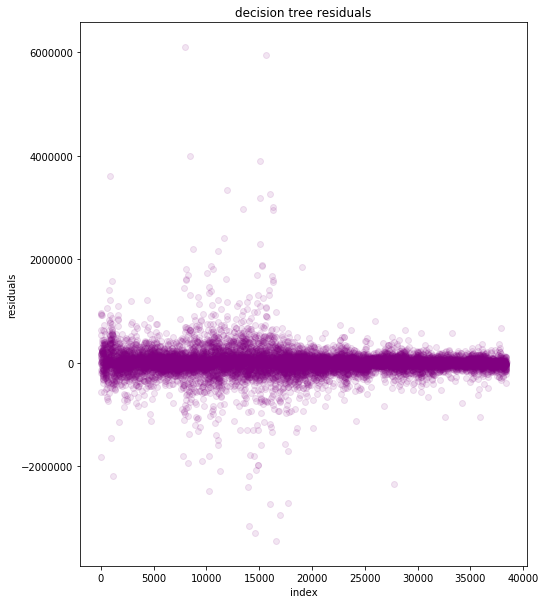

In [224]:
fig, ax = plt.subplots(figsize=(8,10))
residuals = y_test - dtreg.predict(X_test)
ax.scatter(x=y_test.index, y=residuals, alpha=.1,color='purple');
ax.set_xlabel('index')
ax.set_ylabel('residuals')
ax.set_title('decision tree residuals');

In [225]:
fi_dtreg = pd.DataFrame(list(zip(feature_cols, dtreg.feature_importances_)))
fi_dtreg = fi_dtreg.sort_values(1)
fi_dtreg = fi_dtreg[fi_dtreg.loc[:, 1] > .005]
fi_dtreg = fi_dtreg.rename(columns={0:'feature',1:'importance'})
fi_dtreg

,feature,importance
43,neighborhood_Capitol Hill,0.005280
27,grade_Good Quality,0.006063
29,grade_Very Good,0.006217
74,neighborhood_Old City 1,0.006625
13,str_type_Multi,0.008143
0,bath,0.009322
6,yr_rmdl,0.010950
34,condition_Very Good,0.011033
11,fireplaces,0.012746
25,grade_Exceptional-D,0.014598


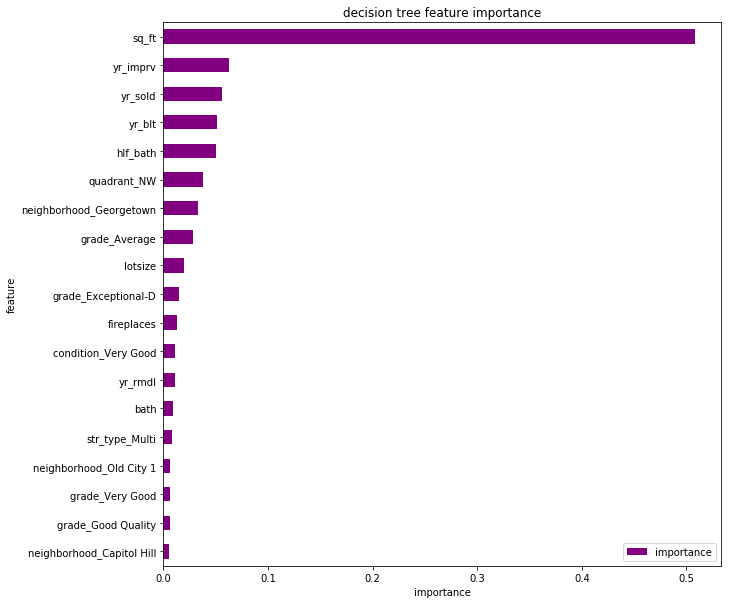

In [226]:
ax = fi_dtreg.plot(kind='barh', x='feature', y='importance', figsize=(10,10), color='purple')
ax.set_xlabel('importance')
ax.set_ylabel('feature')
ax.set_title('decision tree feature importance');

##### Random Forest Regressor

In [227]:
rfr = RandomForestRegressor(n_estimators=200)

rfr.fit(X_train, y_train)

print('Random Forest Regressor Test R^2:', rfr.score(X_test, y_test))       
print('Random Forest Regressor Training R^2:', rfr.score(X_train, y_train))
print('Random Forest Regressor Test MAE:', mean_absolute_error(y_test, rfr.predict(X_test)))
print('Random Forest Regressor Training MAE:', mean_absolute_error(y_train, rfr.predict(X_train)))

## I opted to not use Kfold for this model due to performance and time
## I still have a variance issue, but the MAE is better on the test set than the first two models
## It's still overfitting but not as badly

Random Forest Regressor Test R^2: 0.8807902203699343
Random Forest Regressor Training R^2: 0.9821507944444564
Random Forest Regressor Test MAE: 97351.19940574288
Random Forest Regressor Training MAE: 35911.41452955152


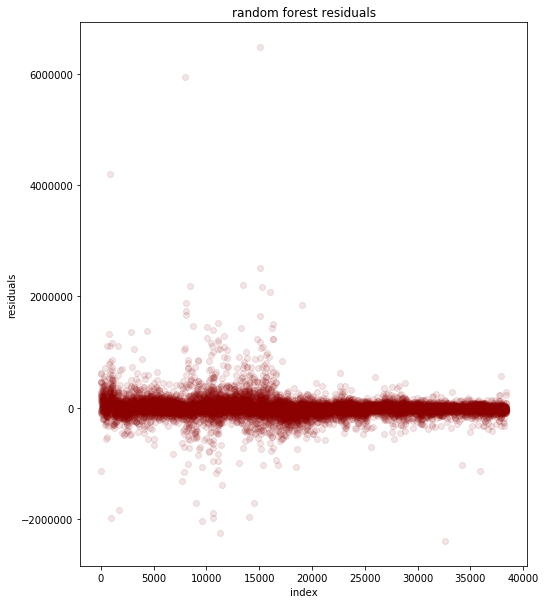

In [228]:
fig, ax = plt.subplots(figsize=(8,10))
residuals = y_test - rfr.predict(X_test)
ax.scatter(x=y_test.index, y=residuals, alpha=.1, color='darkred');
ax.set_xlabel('index')
ax.set_ylabel('residuals')
ax.set_title('random forest residuals');

In [229]:
fi_rfr = pd.DataFrame(list(zip(feature_cols, rfr.feature_importances_)))
fi_rfr = fi_rfr.sort_values(1)
fi_rfr = fi_rfr[fi_rfr.loc[:, 1] > .005]
fi_rfr = fi_rfr.rename(columns={0:'feature',1:'importance'})
fi_rfr

,feature,importance
29,grade_Very Good,0.005040
4,bedrm,0.005230
74,neighborhood_Old City 1,0.006046
2,rooms,0.006657
27,grade_Good Quality,0.006661
0,bath,0.008584
34,condition_Very Good,0.009543
25,grade_Exceptional-D,0.011425
6,yr_rmdl,0.011563
11,fireplaces,0.022496


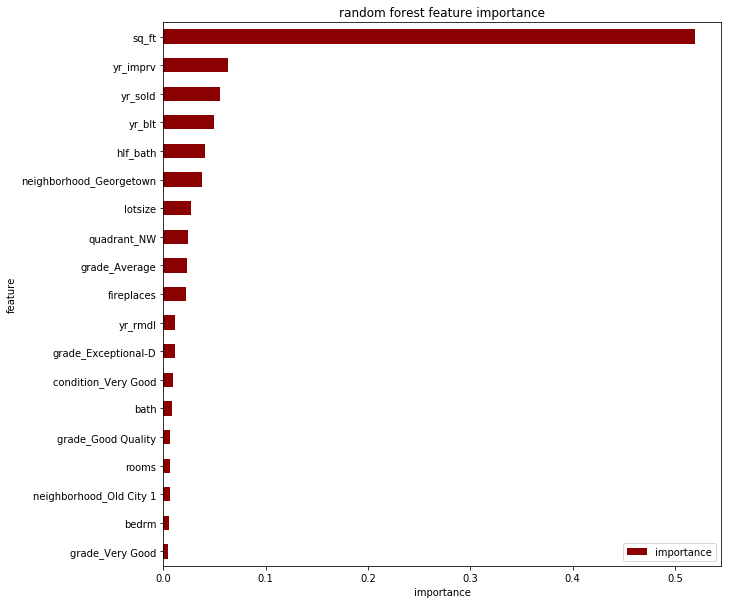

In [230]:
ax = fi_rfr.plot(kind='barh', x='feature', y='importance', figsize=(10,10), color='darkred')
ax.set_xlabel('importance')
ax.set_ylabel('feature')
ax.set_title('random forest feature importance');

##### Bagged Decision Tree Regressor

In [231]:
brfr = RandomForestRegressor(
        n_estimators=500,
        oob_score=True,
        random_state=1)

brfr.fit(X_train, y_train)

print('Random Forest Regressor Test R^2:', brfr.score(X_test, y_test))       
print('Random Forest Regressor Training R^2:', brfr.score(X_train, y_train))
print('Random Forest Regressor OOB R^2:', brfr.oob_score_)
print('Random Forest Regressor Test MAE:', mean_absolute_error(y_test, brfr.predict(X_test)))
print('Random Forest Regressor Training MAE:', mean_absolute_error(y_train, brfr.predict(X_train)))

## I opted to not use Kfold for this model due to performance and time
## I still have a variance issue, but the MAE is just a bit better than the random forest
## It's still overfitting

Random Forest Regressor Test R^2: 0.8815848267307608
Random Forest Regressor Training R^2: 0.9824747709385985
Random Forest Regressor OOB R^2: 0.8698507268310469
Random Forest Regressor Test MAE: 97297.1875102007
Random Forest Regressor Training MAE: 35717.37681751005


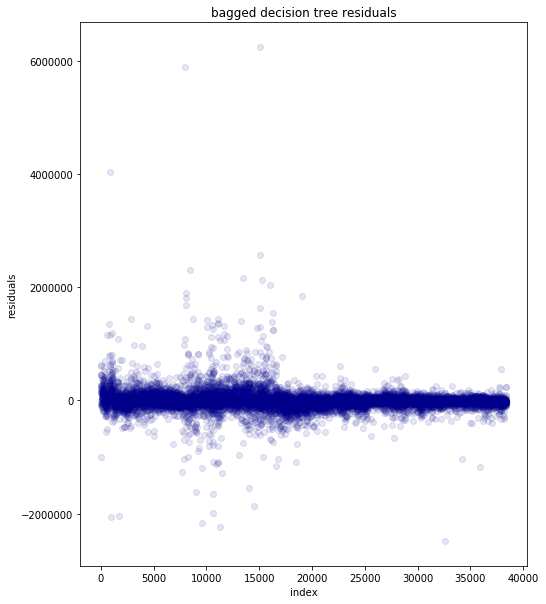

In [232]:
fig, ax = plt.subplots(figsize=(8,10))
residuals = y_test - brfr.predict(X_test)
ax.scatter(x=y_test.index, y=residuals, alpha=.1, color='darkblue');
ax.set_xlabel('index')
ax.set_ylabel('residuals')
ax.set_title('bagged decision tree residuals');

##### I'm going to try reducing the variance by removing less important features from the best performing model

In [233]:
fi_brfr = pd.DataFrame(list(zip(feature_cols, brfr.feature_importances_)))
fi_brfr = fi_brfr.sort_values(1)
fi_brfr = fi_brfr[fi_brfr.loc[:, 1] > .005]
fi_brfr = fi_brfr.rename(columns={0:'feature',1:'importance'})
fi_brfr

,feature,importance
29,grade_Very Good,0.005153
74,neighborhood_Old City 1,0.006266
2,rooms,0.006716
27,grade_Good Quality,0.006945
0,bath,0.008811
34,condition_Very Good,0.009582
25,grade_Exceptional-D,0.011560
6,yr_rmdl,0.011827
20,grade_Average,0.021318
11,fireplaces,0.023424


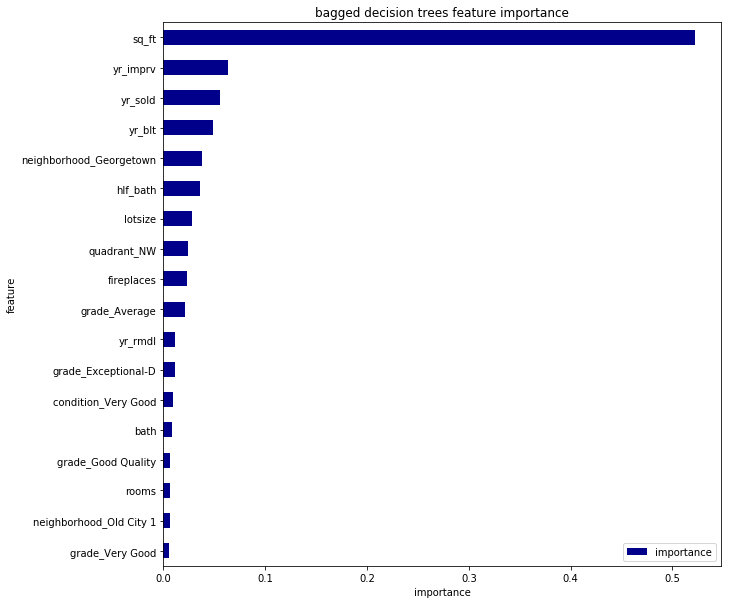

In [234]:
ax = fi_brfr.plot(kind='barh', x='feature', y='importance', figsize=(10,10), color='darkblue')
ax.set_xlabel('importance')
ax.set_ylabel('feature')
ax.set_title('bagged decision trees feature importance');

In [235]:
houses_subset = houses.iloc[:, [11,7,9,5,61,1,13,12,21,6,26,35,0,28,3,75,30]]
houses_subset.head()

,sq_ft,yr_imprv,yr_sold,yr_blt,neighborhood_Georgetown,hlf_bath,lotsize,fireplaces,grade_Average,yr_rmdl,grade_Exceptional-D,condition_Very Good,bath,grade_Good Quality,num_units,neighborhood_Old City 1,grade_Very Good
0,2522.0,1972,2003,1910.0,0,0,1680,5,0,1988.0,0,0,4,0,2.0,0,1
1,2522.0,1984,2016,1910.0,0,1,1680,4,0,2009.0,0,1,3,0,2.0,0,1
2,2484.0,1984,2006,1900.0,0,1,1680,3,0,2003.0,0,0,3,0,2.0,0,1
3,5344.0,1972,2010,1913.0,0,2,2196,4,0,1913.0,0,0,3,0,1.0,0,1
4,2401.0,1972,2011,1906.0,0,1,1627,1,0,2011.0,0,0,3,0,2.0,0,1


In [236]:
target_col2 = houses.loc[:, 'price']
feature_cols2 = houses_subset
y2 = target_col2
X2 = feature_cols2

X_train, X_test, y_train, y_test = train_test_split(X2, y2, train_size=.7, test_size=.3, random_state=10)

In [237]:
brfr2 = RandomForestRegressor(
        n_estimators=500,
        oob_score=True,
        random_state=1)

brfr2.fit(X_train, y_train)

print('Random Forest Regressor Test R^2:', brfr2.score(X_test, y_test))       
print('Random Forest Regressor Training R^2:', brfr2.score(X_train, y_train))
print('Random Forest Regressor OOB R^2:', brfr2.oob_score_)
print('Random Forest Regressor Test MAE:', mean_absolute_error(y_test, brfr2.predict(X_test)))
print('Random Forest Regressor Training MAE:', mean_absolute_error(y_train, brfr2.predict(X_train)))

## This increased variance and the test MAE.  
## I found this to be true when I tried a number of subsets of the feature columns with more and fewer columns included.

Random Forest Regressor Test R^2: 0.8497740273767336
Random Forest Regressor Training R^2: 0.9782933406056759
Random Forest Regressor OOB R^2: 0.8388764281434651
Random Forest Regressor Test MAE: 119829.76596143866
Random Forest Regressor Training MAE: 43936.996394183625


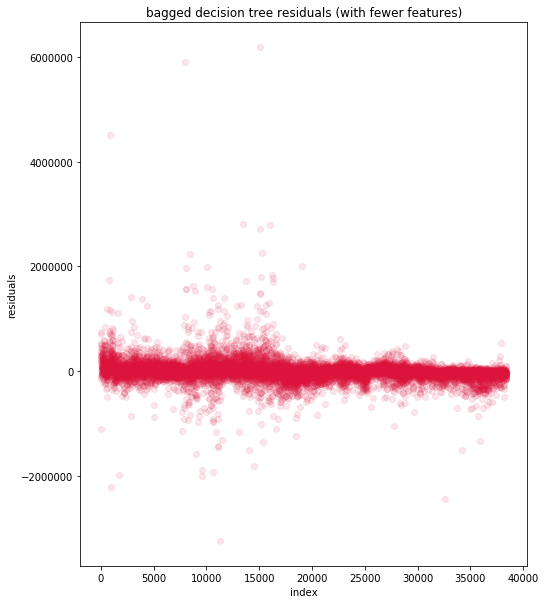

In [239]:
fig, ax = plt.subplots(figsize=(8,10))
residuals = y_test - brfr2.predict(X_test)
ax.scatter(x=y_test.index, y=residuals, alpha=.1, color='crimson');
ax.set_xlabel('index')
ax.set_ylabel('residuals')
ax.set_title('bagged decision tree residuals (with fewer features)');

#### Conclusion

I still have a variance issue in my data.  My instincts are telling me that the huge differential between the lowest and highest prices are causing outliers and edge cases that would take more experience to smooth out.  I also think the huge disparity in home values in the wealthiest and poorest neighborhoods are contributing to the overall variance.  Overall I got my best performance from a Bagged Decision Tree model, but it was only marginally better than the Random Forest model.  I only had about 6 months of 2018 data and I wonder if catching the bare leading edge of the downward trend in prices is affecting the predictions since the prior 15 years show an upward trend.